# From xarray to pandas

## Import python packages

In [37]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import dask
%matplotlib inline

## Open CMIP6 online catalog

In [2]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,517667
dcpp_init_year,60


## Search corresponding data 

In [14]:
cat = col.search(source_id=['CESM2-WACCM'], experiment_id=['historical'], table_id=['AERmon'], variable_id=['so2'], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2-WACCM,historical,r1i1p1f1,AERmon,so2,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227


## Create dictionary from the list of datasets we found
- This step may take several minutes so be patient!

In [44]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [45]:
lconf = list(dset_dict.keys())
print(lconf)

['CMIP.NCAR.CESM2-WACCM.historical.AERmon.gn']


## Open dataset

- Use `xarray` python package to analyze netCDF dataset
- `open_dataset` allows to get all the metadata without loading data into memory. 
- with `xarray`, we only load into memory what is needed.

In [46]:
dset = dset_dict[lconf[0]]
dset = dset.squeeze()

### Get metadata corresponding to the whole dataset

In [47]:
dset

<xarray.Dataset>
Dimensions:    (lat: 192, lev: 70, lon: 288, nbnd: 2, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lev        (lev) float64 -5.96e-06 -9.827e-06 -1.62e-05 ... -976.3 -992.6
    lev_bnds   (lev, nbnd) float32 dask.array<chunksize=(70, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    member_id  <U8 'r1i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    so2        (time, lev, lat, lon) float32 dask.array<chunksize=(5, 70, 192, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    674885.0
    branch_time_in_parent:   20075.0
    case_id:                 4
    ...                      ...
    variable_id:             so2
    variant_info:            CMIP6 CESM2 hindcast (1850-2014) with high-top a...
    variant_label:           r1i1p1f1
    status:                  2019-11-05;created;by nhn2@columbia.edu
    intake_esm_varname:      ['so2']
    intake_esm_dataset_key:  CMIP.NCAR.CESM2-WACCM.historical.AERmon.gn

### Get metadata corresponding to SO2

In [48]:
print(dset['so2'])

<xarray.DataArray 'so2' (time: 1980, lev: 70, lat: 192, lon: 288)>
dask.array<getitem, shape=(1980, 70, 192, 288), dtype=float32, chunksize=(5, 70, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lev        (lev) float64 -5.96e-06 -9.827e-06 -1.62e-05 ... -976.3 -992.6
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    member_id  <U8 'r1i1p1f1'
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Mole fraction is used in the construction mole_fraction_o...
    description:    Mole fraction is used in the construction mole_fraction_o...
    frequency:      mon
    id:             so2
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          SO2 Volume Mixing Ratio
    type:           real
    un

## zonal mean and one level and convert to pandas dataframe

In [67]:
%%time 
dset_selection = dset['so2'].sel(lev=-1000, method='nearest').mean('lon').load()

CPU times: user 4min 53s, sys: 1min 11s, total: 6min 4s
Wall time: 12min 5s


In [68]:
dset_selection

<xarray.DataArray 'so2' (time: 1980, lat: 192)>
array([[4.4148924e-11, 4.3374932e-11, 4.1744469e-11, ..., 2.0261100e-12,
        1.8938171e-12, 1.8695366e-12],
       [3.1989539e-11, 3.1808257e-11, 3.1800659e-11, ..., 1.2741638e-12,
        1.2158472e-12, 1.1790553e-12],
       [2.9416582e-12, 2.6269848e-12, 2.5257598e-12, ..., 6.3785300e-13,
        6.2758875e-13, 6.3872253e-13],
       ...,
       [8.3957434e-13, 8.9930792e-13, 8.8156679e-13, ..., 4.1710988e-12,
        4.0890802e-12, 5.4941021e-12],
       [7.7786545e-12, 7.8954681e-12, 8.0431321e-12, ..., 2.4857640e-11,
        2.7402766e-11, 3.3165942e-11],
       [1.2275407e-11, 1.2175271e-11, 1.2504974e-11, ..., 4.6298299e-10,
        4.6481125e-10, 4.7047843e-10]], dtype=float32)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lev        float64 -992.6
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    member_id  <U8 'r1i1p1f1'

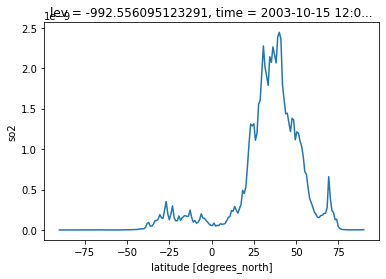

In [76]:
dset_selection.sel(time=cftime.DatetimeNoLeap(2003, 10, 15), method="nearest").plot()

## Convert to pandas dataframe

In [69]:
%%time
pdf = dset_selection.to_dataframe()

CPU times: user 56.4 ms, sys: 2.27 ms, total: 58.7 ms
Wall time: 85.7 ms


In [78]:
pdf.head()

lev member_id           so2
time                lat                                           
1850-01-15 12:00:00 -90.000000 -992.556095  r1i1p1f1  4.414892e-11
                    -89.057592 -992.556095  r1i1p1f1  4.337493e-11
                    -88.115183 -992.556095  r1i1p1f1  4.174447e-11
                    -87.172775 -992.556095  r1i1p1f1  4.043559e-11
                    -86.230366 -992.556095  r1i1p1f1  4.044334e-11

## Drop a column

In [80]:
pdf.drop('member_id', axis=1, inplace=True)

In [81]:
pdf.head()

lev           so2
time                lat                                 
1850-01-15 12:00:00 -90.000000 -992.556095  4.414892e-11
                    -89.057592 -992.556095  4.337493e-11
                    -88.115183 -992.556095  4.174447e-11
                    -87.172775 -992.556095  4.043559e-11
                    -86.230366 -992.556095  4.044334e-11

## Save to local file

In [84]:
pdf.to_csv("CMIP_NCAR_CESM2-WACCM_historical_AERmon_zonal_mean.csv", sep='\t')

## Save your results to Remote private object storage
- your credentials are in `$HOME/.aws/credentials` 
- check with your instructor to get the secret access key (replace XXX by the right key)

```
[default]
aws_access_key_id=forces2021-work
aws_secret_access_key=XXXXXXXXXXXX
aws_endpoint_url=https://forces2021.uiogeo-apps.sigma2.no/
```
<div class="alert alert-success alert-info">
    <b>It is important to save your results in a place that can last longer than a few days/weeks!</b>
</div>

In [85]:
import s3fs

In [86]:
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://forces2021.uiogeo-apps.sigma2.no/'
      })

### Upload local file to remote storage

In [87]:
s3_path =  "s3://work/annefou/CMIP_NCAR_CESM2-WACCM_historical_AERmon_zonal_mean.csv"
print(s3_path)

s3://work/annefou/CMIP_NCAR_CESM2-WACCM_historical_AERmon_zonal_mean.csv


In [88]:
fsg.put('CMIP_NCAR_CESM2-WACCM_historical_AERmon_zonal_mean.csv', s3_path)